<a href="https://colab.research.google.com/github/saivarshitnune/Diabetic-retinory-image-classification/blob/Varshith/Diabetic_retinoapthy_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
import matplotlib.pyplot as plt

In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d pkdarabi/diagnosis-of-diabetic-retinopathy

Dataset URL: https://www.kaggle.com/datasets/pkdarabi/diagnosis-of-diabetic-retinopathy
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/14.9M [00:00<?, ?B/s]
100% 14.9M/14.9M [00:00<00:00, 206MB/s]


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/diagnosis-of-diabetic-retinopathy.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
train_dir = "/content/train"
test_dir = "/content/test"
val_dir = "/content/valid"

In [11]:
# Define image size
img_width, img_height = 224, 224

In [12]:
# Create image data generators
train_datagen = ImageDataGenerator(
                rotation_range=45,
                rescale=1./255,
                # zoom_range=0.5,
                horizontal_flip=True,
                vertical_flip=True
                )
val_datagen = ImageDataGenerator(
                rotation_range=45,
                rescale=1./255,
                # zoom_range=0.5,
                horizontal_flip=True,
                vertical_flip=True
                )

In [13]:
# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode="binary",
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode="binary",
)

Found 2076 images belonging to 2 classes.
Found 531 images belonging to 2 classes.


Application of ResNet 50 Architecture

In [14]:
import keras
import keras.utils
from keras import utils as np_utils
base_model=keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=2,
    classifier_activation="binary",)


94765736/94765736 [==============================] - 0s 0us/step


In [15]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [16]:
# Add two fully-connected layers
x = Flatten()(base_model.output)
x = Dense(128, activation="relu")(x)
x= Dense(64,activation='relu')(x)
predictions = Dense(1, activation="sigmoid")(x)

In [17]:
# Create the model
model2 = Model(inputs=base_model.input, outputs=predictions)

In [18]:
# Compile the model
model2.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001) ,metrics=['Accuracy'])

In [19]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
ckpt_filename= "/content/drive/MyDrive/weightFiles"
checkpoint = ModelCheckpoint(filepath=ckpt_filename+'/'+'model_epoch_{epoch:02d}.h5', save_best_only=True, save_freq='epoch',save_weights_only=True,verbose = 1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1)#
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='min', verbose = 1)

In [20]:
# # Train the model
history=model2.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32,
    callbacks=[checkpoint, lr_reduce, early_stop]
)

Epoch 1/100
64/64 [==============================] - ETA: 0s - loss: 0.7051 - Accuracy: 0.5347
Epoch 1: val_loss improved from inf to 0.64697, saving model to /content/drive/MyDrive/weightFiles/model_epoch_01.h5
64/64 [==============================] - 55s 726ms/step - loss: 0.7051 - Accuracy: 0.5347 - val_loss: 0.6470 - val_Accuracy: 0.5645 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - ETA: 0s - loss: 0.6309 - Accuracy: 0.6737
Epoch 2: val_loss improved from 0.64697 to 0.63128, saving model to /content/drive/MyDrive/weightFiles/model_epoch_02.h5
64/64 [==============================] - 33s 523ms/step - loss: 0.6309 - Accuracy: 0.6737 - val_loss: 0.6313 - val_Accuracy: 0.5820 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - ETA: 0s - loss: 0.6017 - Accuracy: 0.6712
Epoch 3: val_loss did not improve from 0.63128
64/64 [==============================] - 37s 575ms/step - loss: 0.6017 - Accuracy: 0.6712 - val_loss: 0.6432 - val_Accuracy: 0.5430 

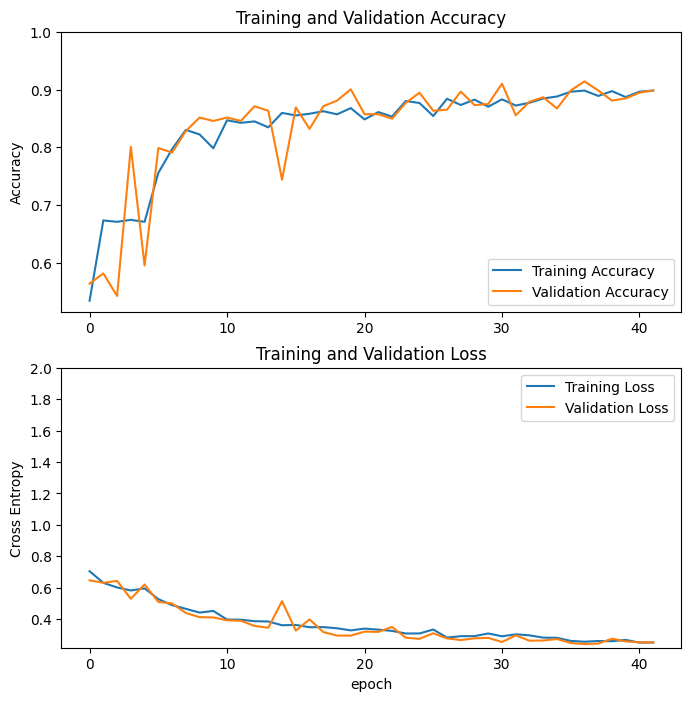

In [21]:
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [25]:
# Evaluate the model on the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode="binary",
    shuffle = False
)

Found 231 images belonging to 2 classes.


In [29]:
loss, accuracy = model2.evaluate(test_generator, steps=test_generator.samples // 32)

7/7 [==============================] - 1s 127ms/step - loss: 0.2614 - Accuracy: 0.9018


In [26]:
# Predict on the test data
predictions = model2.predict(test_generator)

8/8 [==============================] - 3s 248ms/step


In [30]:
y_true = test_generator.classes

In [31]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, predictions)


# Calculate AUC
auc_score = auc(fpr, tpr)

# Find the threshold maximizing Youden's J statistic
max_j_idx = np.argmax(tpr - fpr)
optimal_thresh = thresholds[max_j_idx]

print("AUC:", auc_score)
print("Optimal threshold:", optimal_thresh)

AUC: 0.95995200239988
Optimal threshold: 0.40203407


In [32]:
y_pred = (predictions > optimal_thresh).astype("int32")


In [33]:
# Generate classification report and confusion matrix
print("Classification report:")
print(classification_report(y_true, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       113
           1       0.91      0.92      0.91       118

    accuracy                           0.91       231
   macro avg       0.91      0.91      0.91       231
weighted avg       0.91      0.91      0.91       231



In [34]:
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

Confusion matrix:
[[102  11]
 [ 10 108]]


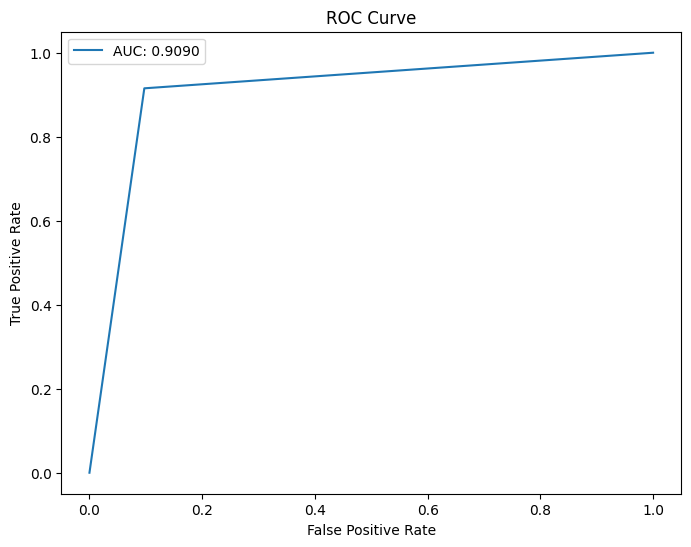

In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Calculate the AUC
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC: {auc_score:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [35]:
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.9018


Analyzing Missclassifications of data

In [37]:
images = test_generator.filepaths

In [38]:
import pandas as pd
df = pd.DataFrame(images,columns=['Test_images'])

In [39]:
df

,Test_images
0,/content/test/DR/00cb6555d108_png.rf.29cca1709...
1,/content/test/DR/0104b032c141_png.rf.2b861f09f...
2,/content/test/DR/03747397839f_png.rf.b634cf9fb...
3,/content/test/DR/04d029cfb612_png.rf.d9cf2e2a4...
4,/content/test/DR/0ada12c0e78f_png.rf.3e8e491a2...
...,...
226,/content/test/No_DR/fca1a8738b8a_png.rf.539925...
227,/content/test/No_DR/fcc32dffd24d_png.rf.794c1f...
228,/content/test/No_DR/fd0a70082e7c_png.rf.c488e8...
229,/content/test/No_DR/fe06dad6851c_png.rf.fa9183...


In [40]:
df['True_labels'] = y_true

In [41]:
df['Predictions'] = y_pred

In [42]:
df

,Test_images,True_labels,Predictions
0,/content/test/DR/00cb6555d108_png.rf.29cca1709...,0,0
1,/content/test/DR/0104b032c141_png.rf.2b861f09f...,0,0
2,/content/test/DR/03747397839f_png.rf.b634cf9fb...,0,0
3,/content/test/DR/04d029cfb612_png.rf.d9cf2e2a4...,0,0
4,/content/test/DR/0ada12c0e78f_png.rf.3e8e491a2...,0,0
...,...,...,...
226,/content/test/No_DR/fca1a8738b8a_png.rf.539925...,1,1
227,/content/test/No_DR/fcc32dffd24d_png.rf.794c1f...,1,1
228,/content/test/No_DR/fd0a70082e7c_png.rf.c488e8...,1,1
229,/content/test/No_DR/fe06dad6851c_png.rf.fa9183...,1,1


In [43]:
df['New'] = df.apply(lambda x: 1 if x['True_labels'] !=
                     x['Predictions'] else np.nan, axis=1)

In [44]:
df = df.dropna()

In [45]:

df = df.drop(['True_labels','Predictions','New'], axis = 1)

In [46]:
df

,Test_images
23,/content/test/DR/2fe06bedb2c4_png.rf.da9fb868c...
35,/content/test/DR/4ccfa0b4e96c_png.rf.74270647a...
38,/content/test/DR/513b0a4651fa_png.rf.7eca236b8...
54,/content/test/DR/76cfe8967f7d_png.rf.bf1e076ea...
57,/content/test/DR/7d1b40fdbd86_png.rf.ef6e5f7ee...
58,/content/test/DR/80e7cc0a0649_png.rf.f635c7edc...
73,/content/test/DR/a11bf2edd470_png.rf.046e939fb...
78,/content/test/DR/a443c4fd489c_png.rf.05837dd6c...
88,/content/test/DR/c62585bd68fb_png.rf.78b563cd5...
98,/content/test/DR/d5b4705ac2ee_png.rf.8d2f70d09...


In [47]:
len(df)

21

In [48]:
# Convert data frame to list
Miss_classified_images = df['Test_images'].values.tolist()

In [49]:
Miss_classified_images

['/content/test/DR/2fe06bedb2c4_png.rf.da9fb868cfdcd75fc063dcd7af59692e.jpg',
 '/content/test/DR/4ccfa0b4e96c_png.rf.74270647ad09f57471c6be8cbf7e536d.jpg',
 '/content/test/DR/513b0a4651fa_png.rf.7eca236b8673dbf5f85efadc0887c26c.jpg',
 '/content/test/DR/76cfe8967f7d_png.rf.bf1e076eafd2e0d1711ba3ffb2b70bd6.jpg',
 '/content/test/DR/7d1b40fdbd86_png.rf.ef6e5f7eeb132ba5246b0649e84eb5e6.jpg',
 '/content/test/DR/80e7cc0a0649_png.rf.f635c7edcc9e7cfd091cb2bf105bc52a.jpg',
 '/content/test/DR/a11bf2edd470_png.rf.046e939fb9d681c606d42bb44ae0c3c6.jpg',
 '/content/test/DR/a443c4fd489c_png.rf.05837dd6c0653d027484e1b79086c9a4.jpg',
 '/content/test/DR/c62585bd68fb_png.rf.78b563cd51fc96c0e4b8e34a63789da3.jpg',
 '/content/test/DR/d5b4705ac2ee_png.rf.8d2f70d09d373d9f329dbffdcc9e5c40.jpg',
 '/content/test/DR/f3a88d3026dc_png.rf.4355ca512a17a5ba9dc838250fd8b856.jpg',
 '/content/test/No_DR/0b2ea8f268cf_png.rf.67217aed13eea5ea2bc2d7dda32aecda.jpg',
 '/content/test/No_DR/30263a7d5609_png.rf.016877dad28b1582994

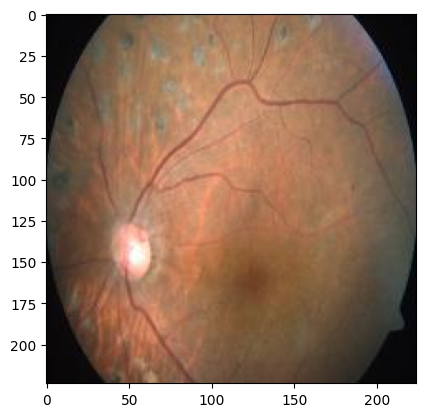

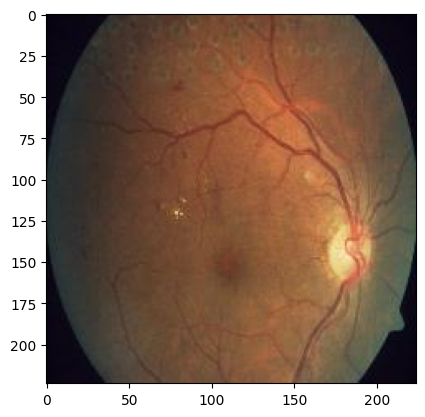

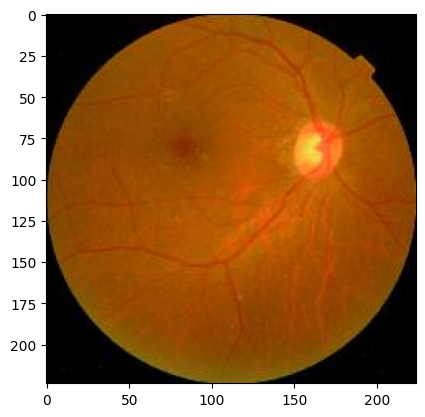

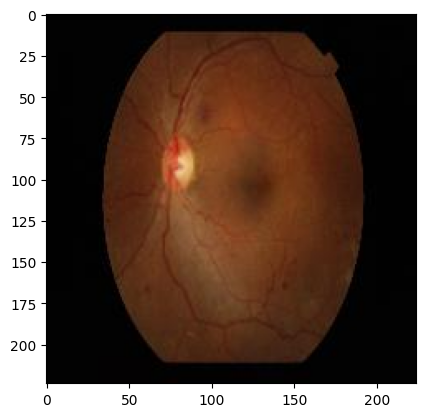

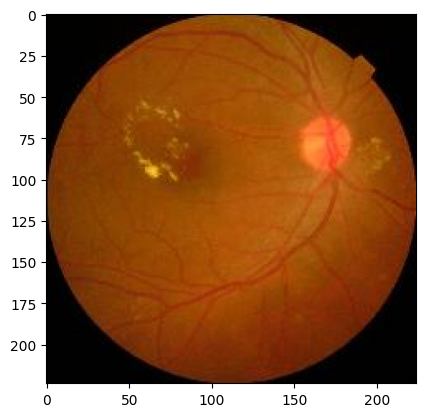

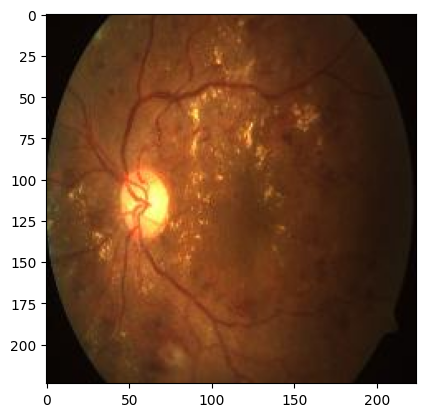

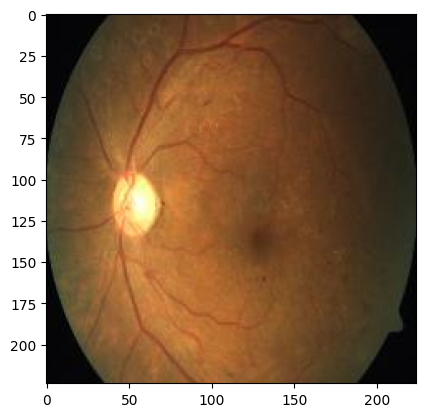

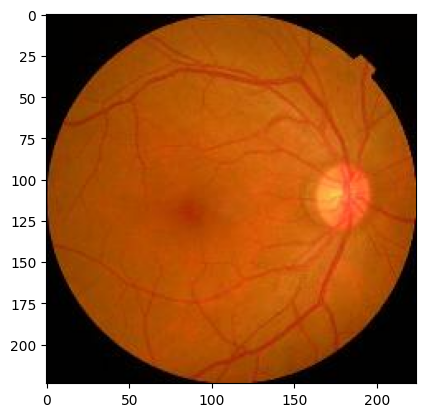

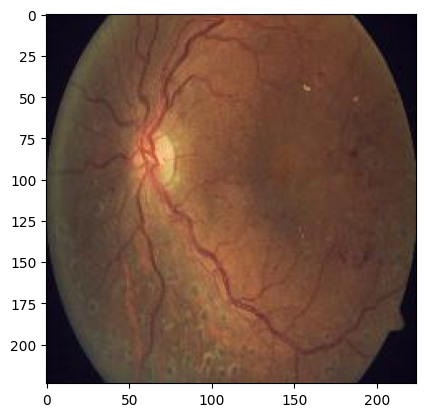

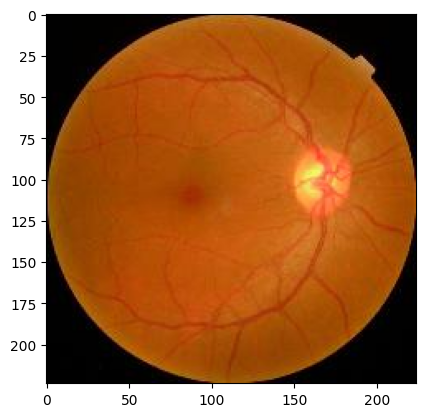

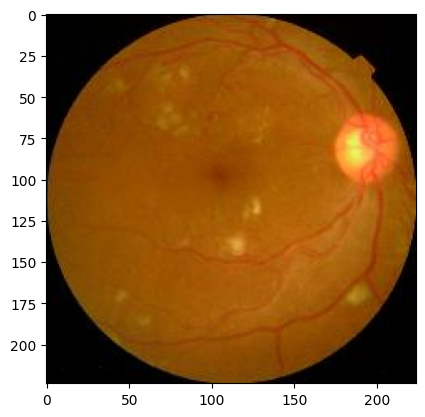

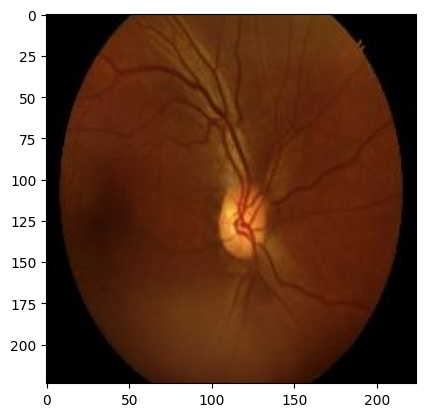

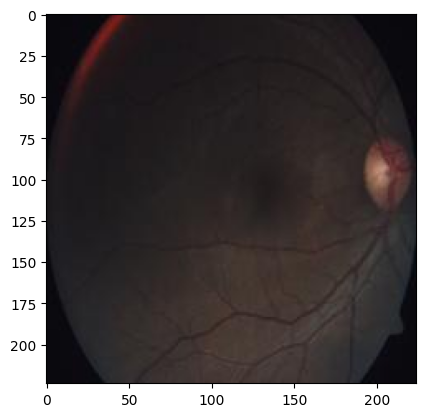

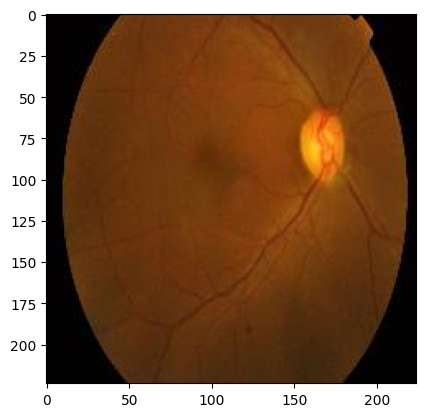

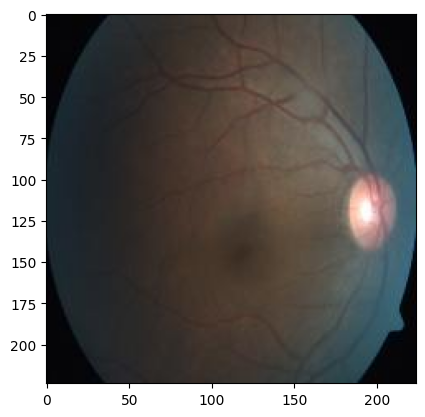

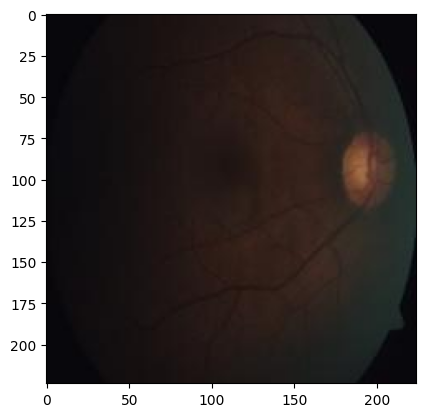

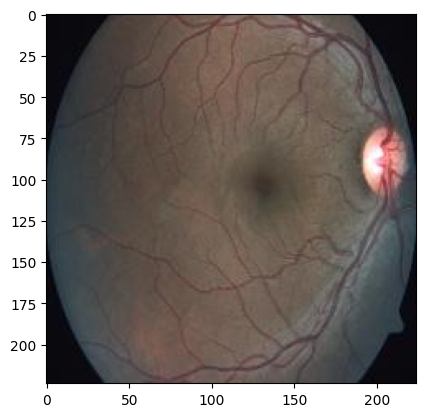

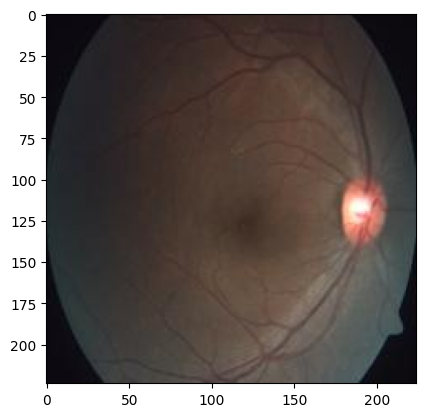

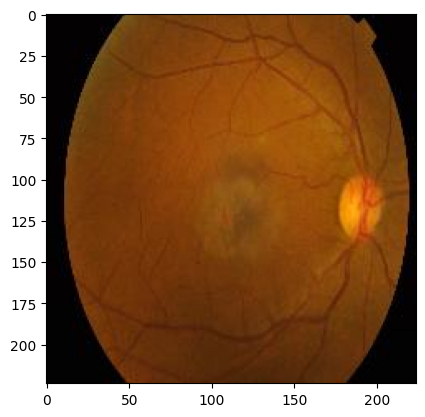

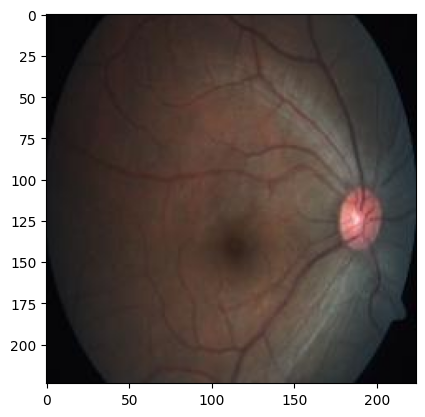

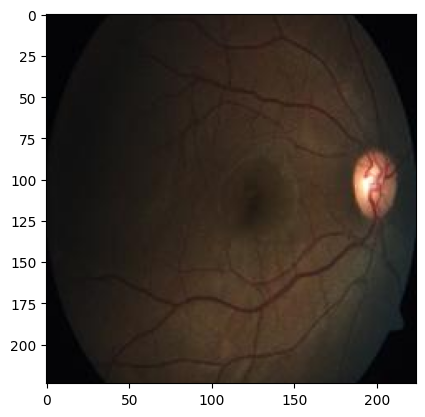

In [50]:
import cv2
import numpy as np
from PIL import Image
for i in Miss_classified_images:
  img = Image.open(i)
  plt.imshow(img)
  plt.show()

Conclusion :-
Compared to VGG16 model the ResNet50 model has more miss classifications since the required amount of data is low while ResNet50 is a large Network has many layers and skip connections so it leads to overfitting for our input data.

Need more amount of data to solve overfitting issue.